# Local Learning on CIFAR10

In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from pathlib import Path
from context import LocalLearning

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [6]:
test_data = LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False, 
    transform=ToTensor()
)

test_dataloader = DataLoader(
    test_data,
    batch_size=1000,
    num_workers=4,
    shuffle=False
)

Files already downloaded and verified


In [29]:
trained_weights_path = Path("../data/models/L2UnitCIFAR10_LL/cifar_990.pth")
cpu = torch.device('cpu')

with torch.no_grad():
    trained_state = torch.load(trained_weights_path)
    model_ps = trained_state["model_parameters"]
    model = LocalLearning.FKHL3(model_ps)
    model.eval()
    model.load_state_dict(trained_state["model_state_dict"])
    model.to(device)
    l_n_trained = LocalLearning.cov_spectrum(test_dataloader, model, device)
    l_n_trained = l_n_trained.to(cpu).numpy()

Calculating covariance spectrum: 100%|████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.93batch/s]


Text(0.5, 1.0, 'CIFAR10 Covariance Spectrum')

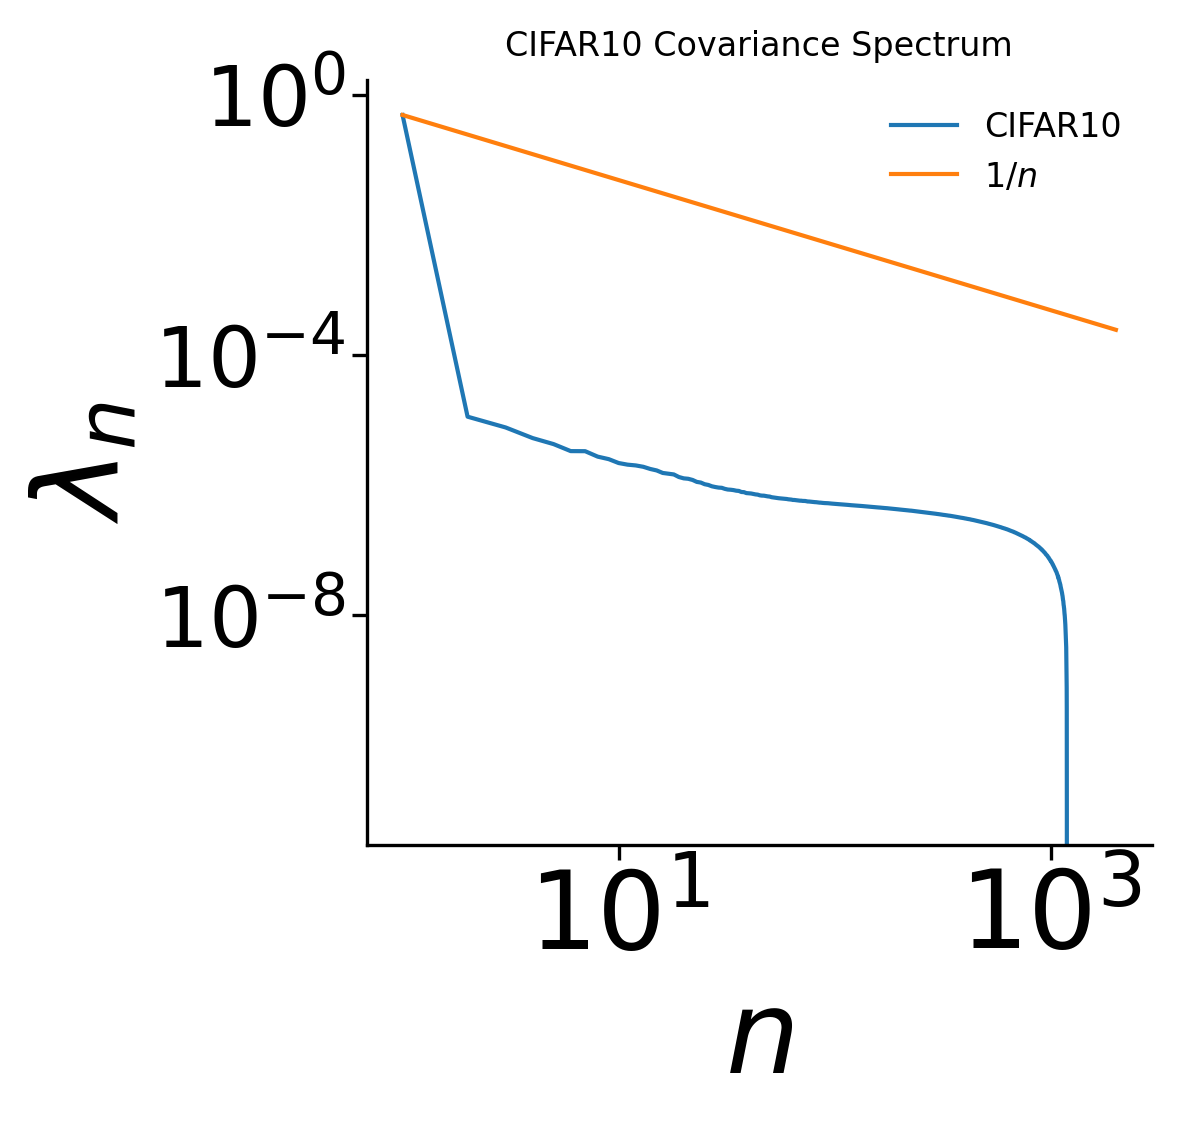

In [46]:
from matplotlib import pyplot as plt
import numpy as np

plt.style.use(['seaborn-paper', "./PRLSingleCol.mplstyle"])

fig, ax = plt.subplots()
ax.loglog(np.arange(1, len(l_n_trained)+1), l_n_trained, label=r"CIFAR10")
ax.loglog(np.arange(1, len(l_n_trained)+1), l_n_trained[0] / np.arange(1, len(l_n_trained)+1), label=r"$1 / n$")
ax.legend()
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$\lambda_{n}$")
ax.set_title(r"CIFAR10 Covariance Spectrum")

array([1., 1., 1.])

# Biological Learning Model

In [1]:
import torch
from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from pathlib import Path
from tqdm import tqdm

from context import LocalLearning

train_data = datasets.CIFAR10(
    root = "../data/CIFAR10", train=True, download=True, transform=ToTensor()
)

dataloader_train = DataLoader(
    train_data, batch_size=128, num_workers=4, shuffle=True
)

Files already downloaded and verified


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model_path = Path("../data/models/L2UnitCIFAR10_LL/llmodel_L2UnitCIFAR10_5.pth")
ll_trained_state = torch.load(model_path)
bio_model = LocalLearning.BioLearningModel(ll_trained_state)
#bio_model.to(device)
bio_model.train()

BioLearningModel(
  (local_learning): LocalLearningModel(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (relu): ReLU()
  (dense): Linear(in_features=2000, out_features=10, bias=False)
  (softmax): Softmax(dim=-1)
)

In [6]:
from matplotlib import pyplot as plt
import numpy as np

#W_pre_training = bio_model.local_learning.W.clone()
#plt.figure()
#plt.hist(list(bio_model.parameters())[0].data.detach().numpy())
#plt.show()

list(bio_model.parameters())[0]

Parameter containing:
tensor([[-0.0716, -0.0728, -0.0742,  ..., -0.0726, -0.0726, -0.0724],
        [-0.0716, -0.0727, -0.0735,  ..., -0.0720, -0.0724, -0.0724],
        [-0.0721, -0.0733, -0.0737,  ..., -0.0728, -0.0729, -0.0738],
        ...,
        [-0.0627, -0.0643, -0.0633,  ..., -0.0643, -0.0637, -0.0644],
        [-0.0622, -0.0641, -0.0633,  ..., -0.0644, -0.0640, -0.0637],
        [-0.0631, -0.0645, -0.0629,  ..., -0.0646, -0.0642, -0.0631]])

In [28]:
learning_rate = lambda l: 0.02

In [29]:
learning_rate(4.0)

0.02

In [ ]:
import torch.optim 
import numpy as np
from matplotlib import pyplot as plt

#optimizer = torch.optim.Adam(bio_model.parameters(), lr=0.0001)

steps = 0

plt.figure()

for i in range(1):
    for features, labels in dataloader_train:
        #optimizer.zero_grad()
        pred = bio_model(features)
        plt.hist(np.ravel(pred.detach().numpy()), bins=np.linspace(0.0, 1.0, num=20), )
        #print(pred)
        #labels_one_hot = torch.zeros(pred.size())
        #labels_one_hot.scatter_(-1, labels[..., None], 1.0)
        #loss = torch.pow(pred - labels_one_hot, 4.0).sum()
        #loss.backward()
        #optimizer.step()
        steps += 1
        #print(list(bio_model.parameters())[1])
    
print(steps)
plt.show()

In [20]:
W_post = list(bio_model.parameters())[1].data
torch.equal(W_pre, W_post)

True

# End-to-end backpropagation model

In [1]:
import torch
from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from pathlib import Path
from tqdm import tqdm

In [2]:
class Classifier(nn.Module):
    
    def __init__(self):
        super(Classifier, self).__init__()
        self.flatten = nn.Flatten()
        self.flatten.requires_grad_(False)
        self.hidden = nn.Linear(32*32*3, 2000, bias=False)
        self.hidden.requires_grad_(False)
        self.relu = nn.ReLU()
        self.dense = nn.Linear(2000, 10, bias=False)
        self.relu_two = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x: Tensor) -> Tensor:
        hidden = self.hidden(self.flatten(x))
        activation = torch.pow(self.relu(hidden), 4.5)
        return self.softmax(self.dense(activation))

classifier = Classifier()
classifier.train()

Classifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=3072, out_features=2000, bias=False)
  (relu): ReLU()
  (dense): Linear(in_features=2000, out_features=10, bias=False)
  (relu_two): ReLU()
  (softmax): Softmax(dim=-1)
)

In [5]:
train_data = datasets.CIFAR10(
    root = "../data/CIFAR10", train=True, download=True, transform=ToTensor()
)

dataloader_train = DataLoader(
    train_data, batch_size=128, num_workers=4, shuffle=True
)

Files already downloaded and verified


In [6]:
list(classifier.parameters())

[Parameter containing:
 tensor([[-0.0057, -0.0161,  0.0151,  ...,  0.0126,  0.0153, -0.0043],
         [-0.0178, -0.0174, -0.0080,  ..., -0.0031,  0.0024, -0.0178],
         [-0.0128,  0.0065, -0.0057,  ...,  0.0036, -0.0115, -0.0179],
         ...,
         [ 0.0143,  0.0145, -0.0003,  ...,  0.0177,  0.0071, -0.0105],
         [-0.0047,  0.0028, -0.0154,  ...,  0.0027,  0.0038, -0.0042],
         [ 0.0141,  0.0036,  0.0101,  ...,  0.0180,  0.0167,  0.0016]]),
 Parameter containing:
 tensor([[ 0.0110,  0.0190, -0.0184,  ..., -0.0133,  0.0010, -0.0182],
         [ 0.0149,  0.0203,  0.0185,  ..., -0.0199,  0.0076, -0.0182],
         [-0.0079, -0.0096, -0.0169,  ...,  0.0033,  0.0203,  0.0060],
         ...,
         [ 0.0180,  0.0166,  0.0055,  ..., -0.0124, -0.0059, -0.0129],
         [ 0.0084, -0.0085, -0.0119,  ...,  0.0105,  0.0023, -0.0041],
         [ 0.0135,  0.0062,  0.0137,  ...,  0.0090, -0.0057, -0.0153]],
        requires_grad=True)]

In [7]:
import torch.optim 

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

for features, labels in dataloader_train:
    optimizer.zero_grad()
    pred = classifier(features)
    labels_one_hot = torch.zeros(pred.size())
    labels_one_hot.scatter_(-1, labels[..., None], 1.0)
    loss = torch.pow(pred - labels_one_hot, 6.0).sum()
    loss.backward()
    optimizer.step()

In [8]:
list(classifier.parameters())

[Parameter containing:
 tensor([[-0.0057, -0.0161,  0.0151,  ...,  0.0126,  0.0153, -0.0043],
         [-0.0178, -0.0174, -0.0080,  ..., -0.0031,  0.0024, -0.0178],
         [-0.0128,  0.0065, -0.0057,  ...,  0.0036, -0.0115, -0.0179],
         ...,
         [ 0.0143,  0.0145, -0.0003,  ...,  0.0177,  0.0071, -0.0105],
         [-0.0047,  0.0028, -0.0154,  ...,  0.0027,  0.0038, -0.0042],
         [ 0.0141,  0.0036,  0.0101,  ...,  0.0180,  0.0167,  0.0016]]),
 Parameter containing:
 tensor([[-0.1682, -0.0894, -0.1055,  ..., -0.0870, -0.1443, -0.0445],
         [ 0.0597, -0.0100,  0.0443,  ...,  0.1123,  0.0917,  0.0718],
         [-0.0711,  0.0364, -0.1270,  ..., -0.1561, -0.1763, -0.1152],
         ...,
         [ 0.0317,  0.0624,  0.0866,  ..., -0.1071, -0.0031, -0.0434],
         [-0.1795, -0.1541, -0.1571,  ...,  0.0341, -0.0771, -0.0836],
         [ 0.1219, -0.1365,  0.1390,  ..., -0.0028,  0.1732,  0.0729]],
        requires_grad=True)]

{'model_state_dict': OrderedDict([('W',
               tensor([[-0.0741, -0.0739, -0.0741,  ..., -0.0742, -0.0741, -0.0739],
                       [-0.0737, -0.0737, -0.0736,  ..., -0.0736, -0.0738, -0.0737],
                       [-0.0741, -0.0743, -0.0742,  ..., -0.0740, -0.0742, -0.0744],
                       ...,
                       [-0.0646, -0.0644, -0.0645,  ..., -0.0647, -0.0645, -0.0644],
                       [-0.0647, -0.0643, -0.0648,  ..., -0.0645, -0.0644, -0.0647],
                       [-0.0651, -0.0649, -0.0648,  ..., -0.0647, -0.0647, -0.0649]],
                      device='cuda:0'))]),
 'model_parameters': {'in_size': 3072,
  'hidden_size': 2000,
  'n': 4.5,
  'p': 3,
  'tau_l': 5000.0,
  'k': 7,
  'Delta': 0.4,
  'R': 1.0},
 'device_type': 'cuda'}